# Statistical Methods

**Notebook:** `statistical_methods.ipynb`

**Purpose:** Demonstrate sample selection, confidence intervals, hypothesis tests, correlation coefficients, and linear regression examples.

In [3]:
import pandas as pd, numpy as np
from pathlib import Path
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
pd.options.display.float_format = '{:,.3f}'.format

df = pd.read_csv('../data/tourism_clean.csv', parse_dates=['date'])
df = df.sort_values('date').reset_index(drop=True)
print('Rows after cleaning:', len(df))

Rows after cleaning: 180


## 1) Sample selection

We will create two samples:
- `full_sample`: the full cleaned dataset for descriptive work.
- `infer_sample`: a stratified random sample by year (to preserve representation across years) used for inferential examples.

In [4]:
# Full sample
full_sample = df.copy()

# Stratified sample: sample 30% of months per year (minimum 1 per year)
def stratified_by_year(data, frac=0.3, random_state=42):
    sampled = data.groupby('year', group_keys=False).apply(lambda x: x.sample(max(1, int(np.ceil(len(x)*frac))), random_state=random_state))
    return sampled

infer_sample = stratified_by_year(df, frac=0.3)
print('Full sample size:', len(full_sample))
print('Inferential sample size:', len(infer_sample))

Full sample size: 180
Inferential sample size: 60


C:\Users\nimes\AppData\Local\Temp\ipykernel_14080\3507686151.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled = data.groupby('year', group_keys=False).apply(lambda x: x.sample(max(1, int(np.ceil(len(x)*frac))), random_state=random_state))


## 2) Confidence intervals

Compute a 95% CI for mean `avg_stay` using t-distribution.

In [5]:
# Confidence interval for avg_stay (95%)
x = infer_sample['avg_stay'].dropna()
n = len(x)
mean = x.mean()
std = x.std(ddof=1)
se = std / np.sqrt(n)
ci_low, ci_high = stats.t.interval(0.95, df=n-1, loc=mean, scale=se)
print(f'n={n}, mean={mean:.3f}, 95% CI=({ci_low:.3f}, {ci_high:.3f})')

n=60, mean=9.628, 95% CI=(8.927, 10.328)


## 3) Hypothesis testing

Example: Do average daily spends differ between `pre_2020` and `post_2020` periods? We'll use Welch's t-test (unequal variance). Exclude pandemic zeros and 2020 period.

In [6]:
pre = df[(df['year']<=2019) & (df['avg_daily_spend']>0)]['avg_daily_spend'].dropna()
post = df[(df['year']>=2021) & (df['avg_daily_spend']>0)]['avg_daily_spend'].dropna()
tstat, pval = stats.ttest_ind(pre, post, equal_var=False)
print('pre mean=', pre.mean(), 'post mean=', post.mean())
print('Welch t-test: t=', round(tstat,3), 'p=', round(pval,4))

pre mean= 133.80291666666668 post mean= 45.276666666666664
Welch t-test: t= 28.541 p= 0.0


If p < 0.05 we reject the null of equal means at 5% significance.

## 4) Correlation coefficients

Compute Pearson and Spearman between arrivals and revenue.

In [7]:
arr = df['tourist_arrivals'].replace(0, np.nan).dropna()
rev = df['tourism_revenue_usd'].replace(0, np.nan).dropna()
# align indices
tmp = df[['tourist_arrivals','tourism_revenue_usd']].replace(0, np.nan).dropna()
pearson_r, pearson_p = stats.pearsonr(tmp['tourist_arrivals'], tmp['tourism_revenue_usd'])
spearman_r, spearman_p = stats.spearmanr(tmp['tourist_arrivals'], tmp['tourism_revenue_usd'])
print('Pearson r=', round(pearson_r,3), 'p=', round(pearson_p,4))
print('Spearman rho=', round(spearman_r,3), 'p=', round(spearman_p,4))

Pearson r= 0.957 p= 0.0
Spearman rho= 0.968 p= 0.0


## 5) Linear regression (OLS)

Model tourism_revenue_usd as a function of arrivals and other predictors.

In [8]:
# Prepare data: drop zero-revenue months and NA
model_df = df[df['tourism_revenue_usd']>0].copy()
model_df = model_df.dropna(subset=['tourism_revenue_usd','tourist_arrivals','avg_stay','avg_daily_spend','hotel_occupancy_rate','exchange_rate_lkr_usd'])

formula = 'tourism_revenue_usd ~ tourist_arrivals + avg_stay + avg_daily_spend + hotel_occupancy_rate + exchange_rate_lkr_usd'
model = smf.ols(formula=formula, data=model_df).fit()
print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     tourism_revenue_usd   R-squared:                       0.955
Model:                             OLS   Adj. R-squared:                  0.954
Method:                  Least Squares   F-statistic:                     705.2
Date:                 Sat, 06 Sep 2025   Prob (F-statistic):          2.42e-109
Time:                         14:05:50   Log-Likelihood:                -3134.1
No. Observations:                  171   AIC:                             6280.
Df Residuals:                      165   BIC:                             6299.
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept           

### Diagnostics: residual plot and VIF

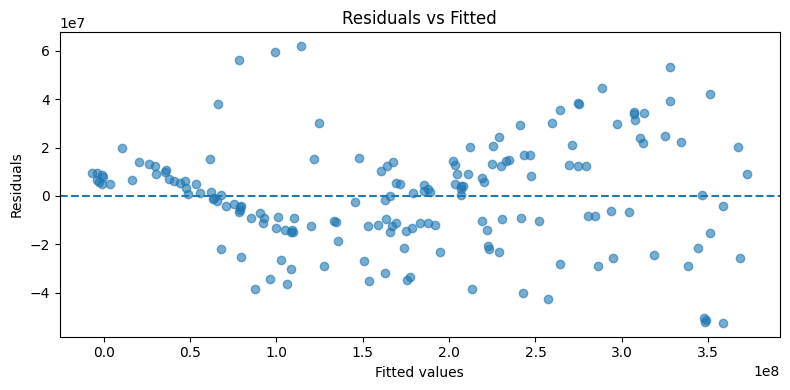

VIFs: {'tourist_arrivals': np.float64(3.0012447270723146), 'avg_stay': np.float64(2.907595335313397), 'avg_daily_spend': np.float64(3.259142670122251), 'hotel_occupancy_rate': np.float64(6.096335110621386), 'exchange_rate_lkr_usd': np.float64(6.627458202927905)}


In [10]:
# Residual plot
from matplotlib import pyplot as plt


resid = model.resid
fitted = model.fittedvalues
plt.figure(figsize=(8,4))
plt.scatter(fitted, resid, alpha=0.6)
plt.axhline(0, linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.tight_layout()
plt.show()

# VIF (variance inflation factor)
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = model_df[['tourist_arrivals','avg_stay','avg_daily_spend','hotel_occupancy_rate','exchange_rate_lkr_usd']].assign(const=1)
vifs = {col: variance_inflation_factor(X.values, i) for i,col in enumerate(X.columns) if col!='const'}
print('VIFs:', vifs)